In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/credit-card-approval-prediction/credit_record.csv
/kaggle/input/credit-card-approval-prediction/application_record.csv


In [2]:
# variables

# paths for files
app_path_str = "../input/credit-card-approval-prediction/application_record.csv"
credit_path_str = "../input/credit-card-approval-prediction/credit_record.csv"
# For random forest, a number of trees must be selected.
# The higher number, the more thorough the calculation, but it takes longer to run.
number_of_trees = 200
# Target column for random forest prediction
target_column_name = 'high_risk'
# Usually, decision trees can be large.  Setting this variable to 3 or 4 makes the result tree easier to see and interpret.
tree_depth = 3

In [3]:
#  Load data
# create dataframe from data
df_app = pd.read_csv(app_path_str)
df_app.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


In [4]:
#  Load data
# create dataframe from data

df_credit = pd.read_csv(credit_path_str)
df_credit.shape

(1048575, 3)

In [5]:
#  Replace C and X with 0, expanding the 0 group to 0-29 days past due, so that we have all numeric categories for delinquency status.
df_credit['STATUS'] = df_credit['STATUS'].replace(['X'],0)
df_credit['STATUS'] = df_credit['STATUS'].replace(['C'],0)

# check rows,cols
df_app.shape

(438557, 18)

In [6]:
# Convert status to numeric and group-max by status for each unique id.  
# This will be a proxy for whether an applicant will be approved, since there is no yes/no flag for approved in the data set.
df_credit['STATUS'] = df_credit['STATUS'].apply(pd.to_numeric) 
# Select highest status, i.e. the highest level of delinquency for each customer id
df_credit = df_credit.groupby('ID')['STATUS'].max().reset_index()
# export data to csv file
df_credit.to_csv('df_credit.csv',index=False)

df_credit.groupby('ID')['STATUS'].count().reset_index()

,ID,STATUS
0,5001711,1
1,5001712,1
2,5001713,1
3,5001714,1
4,5001715,1
...,...,...
45980,5150482,1
45981,5150483,1
45982,5150484,1
45983,5150485,1


In [7]:
#  Join grouped status table to df_app by ID 
df_consol = pd.merge(df_app, df_credit, left_on='ID', right_on='ID')
df_consol.shape

(36457, 19)

In [8]:
# convert status to binary.  If < 1, then 
df_consol['high_risk'] = np.where(df_consol['STATUS']<1, 0, 1)
# convert days old to years
df_consol['age_years'] = round(df_consol['DAYS_BIRTH']/-365,0).astype(int)
df_consol['years_employed'] = round(df_consol['DAYS_EMPLOYED']/-365,0).astype(int)


df_consol.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,...,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,STATUS,high_risk,age_years,years_employed
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,...,1,1,0,0,NaN,2.0,1,1,33,12
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,...,1,1,0,0,NaN,2.0,1,1,33,12
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,...,1,0,0,0,Security staff,2.0,0,0,59,3
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,...,1,0,1,1,Sales staff,1.0,0,0,52,8
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,...,1,0,1,1,Sales staff,1.0,0,0,52,8


In [9]:
#  Encode categorical columns
df_formatted = pd.get_dummies(df_consol, columns=['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 
                                   'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE'],               
               prefix=["gender", "own_car", 'own_property', 'income_type', 'education', 'family_status', 'housing_type',
                      'occupation_type'])
# check length-rows and width-columns of data
df_formatted.shape

(36457, 59)

In [10]:
# drop columns not needed
df_formatted.drop(['ID'], axis=1, inplace=True)
df_formatted.drop(['STATUS'], axis=1, inplace=True)
df_formatted.drop(['DAYS_BIRTH'], axis=1, inplace=True)
df_formatted.drop(['DAYS_EMPLOYED'], axis=1, inplace=True)
df_formatted.drop(['own_car_N'], axis=1, inplace=True)
df_formatted.drop(['own_property_N'], axis=1, inplace=True)

df_formatted.to_csv('df_formatted.csv',index=False)

In [11]:
# Use numpy to convert to arrays.
# NumPy is a library for the Python programming language, adding support for large, multi-dimensional arrays and matrices, 
# along with a large collection of high-level mathematical functions to operate on these arrays.
import numpy as np

# Assign target variable to separate array
target = np.array(df_formatted[target_column_name])

# Remove target column from features
features = df_formatted.drop(target_column_name, axis = 1)

# Saving feature names for later use
feature_list = list(features.columns)

# convert features dataframe to array
features = np.array(features)

In [12]:
#  Using Skicit-learn to split data into training and testing sets.
#  Scikit-learn (formerly scikits.learn and also known as sklearn) is a free software machine learning library for the Python programming language.
#  It features various classification, #  regression and clustering algorithms including support vector machines, random forests, 
#  gradient boosting, k-means and DBSCAN, and is designed to interoperate with the Python numerical and scientific libraries NumPy and SciPy.
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets.  test_size is n% of the rows. The other % will train the model.
train_features, test_features, train_target, test_target = train_test_split(features, target, test_size = 0.25, random_state = 42)

# Check to see that training features and labels have the same rows, and testing features and labels have the same rows
print('Training Features Shape:', train_features.shape)
print('Training target Shape:', train_target.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing target Shape:', test_target.shape)

Training Features Shape: (27342, 52)
Training target Shape: (27342,)
Testing Features Shape: (9115, 52)
Testing target Shape: (9115,)


In [13]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor

# Instantiate model.  n_estimators is the number of decision trees you want to use
rf = RandomForestRegressor(n_estimators = number_of_trees, random_state = 42)

# Train the model on training data
rf.fit(train_features, train_target)

RandomForestRegressor(n_estimators=200, random_state=42)

In [14]:
# Import tools needed for visualization
from sklearn.tree import export_graphviz
from IPython.display import Image
# pydot may need to be installed. 
try:
    import pydot
except ImportError as e:
    !pip install pydot
    import pydot

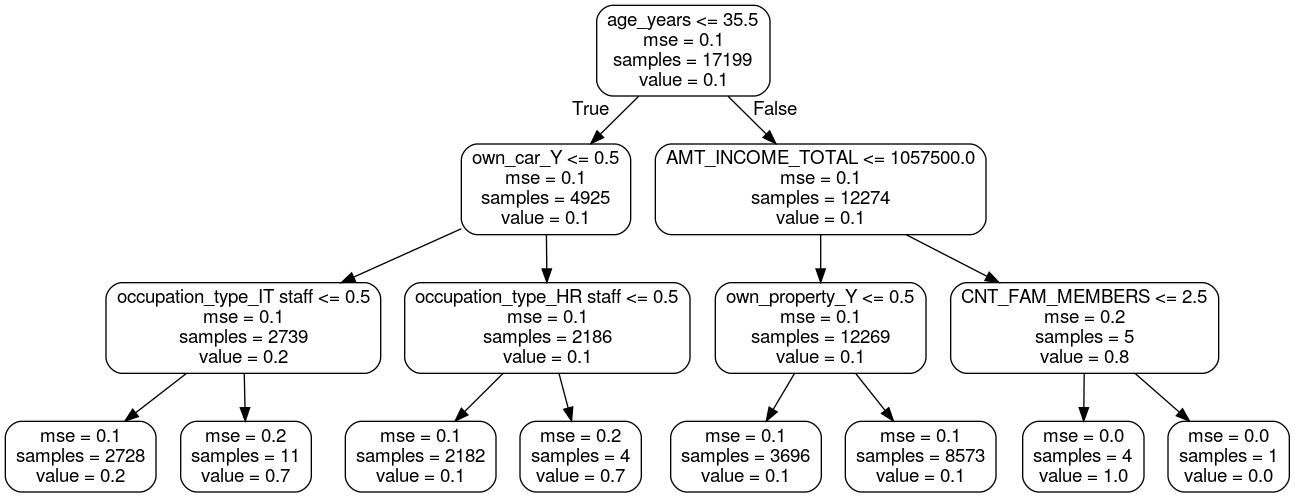

In [15]:
# Limit depth of tree to n levels
rf_small = RandomForestRegressor(n_estimators=10, max_depth = tree_depth)
rf_small.fit(train_features, train_target)
# Extract the small tree
tree_small = rf_small.estimators_[5]
# Save the tree as a png image
export_graphviz(tree_small, out_file = 'small_tree.dot', feature_names = feature_list, rounded = True, precision = 1)
(graph, ) = pydot.graph_from_dot_file('small_tree.dot')
graph.write_png('small_tree.png')
# show png file
Image(graph.create_png())

In [16]:
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

Variable: AMT_INCOME_TOTAL     Importance: 0.18
Variable: age_years            Importance: 0.17
Variable: years_employed       Importance: 0.13
Variable: CNT_FAM_MEMBERS      Importance: 0.04
Variable: CNT_CHILDREN         Importance: 0.03
Variable: FLAG_PHONE           Importance: 0.03
Variable: FLAG_WORK_PHONE      Importance: 0.02
Variable: FLAG_EMAIL           Importance: 0.02
Variable: gender_F             Importance: 0.02
Variable: gender_M             Importance: 0.02
Variable: own_car_Y            Importance: 0.02
Variable: own_property_Y       Importance: 0.02
Variable: income_type_Commercial associate Importance: 0.02
Variable: income_type_Working  Importance: 0.02
Variable: education_Higher education Importance: 0.02
Variable: education_Secondary / secondary special Importance: 0.02
Variable: family_status_Married Importance: 0.02
Variable: occupation_type_Core staff Importance: 0.02
Variable: occupation_type_Laborers Importance: 0.02
Variable: income_type_Pensioner Importan

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [17]:
dfcorr = df_formatted[['AMT_INCOME_TOTAL','age_years','years_employed', 'high_risk']]

In [18]:
# import packages
import seaborn as sn
import matplotlib.pyplot as plt

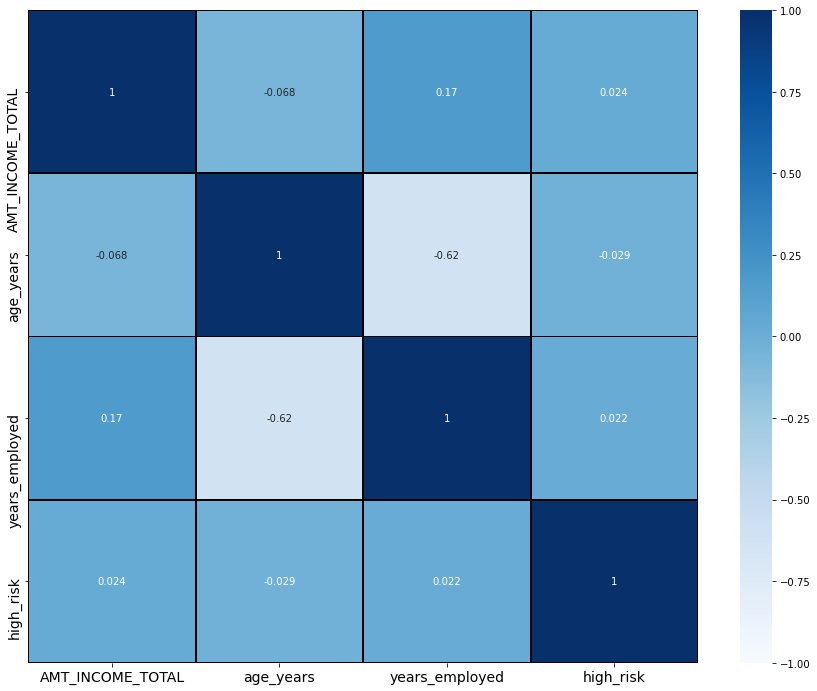

In [19]:
# set width and height 
f = plt.figure() 
f.set_figwidth(15) 
f.set_figheight(12) 

# create matrix
sn.heatmap(dfcorr.corr(), annot = True, vmin=-1, vmax=1, center= 0, cmap= 'Blues', linewidths=1, linecolor='black')
# Make x and y descriptions larger so they are easier to read
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.show()